Number of failed tests: 2


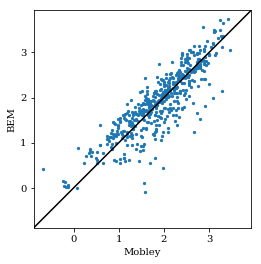

In [202]:
import numpy
from matplotlib import pyplot
%matplotlib inline

bem_es = numpy.loadtxt('energy_bem_phi10_eps62.txt')
test_charge = numpy.loadtxt('test_charge.txt')
bem_lj = numpy.loadtxt('vdw_energy_d20.txt')

bem = bem_es + bem_lj

mobley = numpy.loadtxt('mobley_results_clean.txt')
names = numpy.loadtxt('actually_all_names_michael.txt', dtype=str)
volumes = numpy.loadtxt('volumes_fix.txt')
areas = numpy.loadtxt('areas_fix.txt')
volumes_s = numpy.loadtxt('volumes_stern_fix.txt')
areas_s = numpy.loadtxt('areas_stern_fix.txt')

michael_array = []
for i in range(len(names)):
    if names[i][0]=='_':
        names[i] = names[i][1:]
        michael_array.append(i)
michael_array = numpy.array(michael_array)
 
    
smiles_file = 'mobley_test/smiles/smiles.txt'
smiles = numpy.chararray(len(mobley), itemsize=30)
i=0
for line in file(smiles_file):
    line = line.split()
    smiles[i] = line[-1]
    i += 1

index_clean = numpy.where(abs(bem)>1e-12)[0]

index_clean = michael_array

print 'Number of failed tests: %i'%(len(bem)-len(index_clean))

fig,ax = pyplot.subplots()
ax.scatter(mobley[index_clean], bem[index_clean], s=5)

lims = [ 
    numpy.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    numpy.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(numpy.array([lims[0],lims[1]]), numpy.array([lims[0],lims[1]]), c='k')

ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Mobley')
ax.set_ylabel('BEM')
fig.savefig('comparison.pdf')
fig.show()

In [203]:
index_fail = numpy.where(abs(bem)<1e-12)[0]
index_fail

array([229, 341])

In [204]:
names[229], names[341]

('ammonia', 'hydrogen_sulfide')

In [241]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

bem_c = bem[index_clean]
mobley_c = mobley[index_clean]
names_c = names[index_clean]
volumes_c = volumes[index_clean]
areas_c = areas[index_clean]
test_charge_c = test_charge[index_clean]
smiles_c = smiles[index_clean]

key = 'Cl'
key_true = numpy.chararray(len(bem_c), itemsize=10)
key_true[:] = 'blue'
for i in range(len(bem_c)):
    if key in smiles_c[i]:
        key_true[i] = 'red'
    
trace = go.Scatter(
            x = mobley_c,
            y = bem_c,
            text = smiles_c,
            mode='markers',
            marker = dict(size=8,
                        opacity=0.6, color=key_true),
#                        opacity=0.6, color=areas_c),
            hoverinfo = 'text')


max_val = numpy.max(mobley_c)
ref = go.Scatter( x = numpy.array([0,max_val]),
                  y = numpy.array([0,max_val]),
                  mode = 'lines'
                )

ref2 = go.Scatter( x = numpy.array([0,max_val]),
                  y = numpy.array([1,max_val+1]),
                  mode = 'lines'
                )
ref3 = go.Scatter( x = numpy.array([0,max_val]),
                  y = numpy.array([-1,max_val-1]),
                  mode = 'lines'
                )

data = [trace, ref, ref2, ref3]
    
layout= go.Layout(
    title= 'BEM vs Explicit Nonpolar Solvation Energy',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Explicit',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'BEM',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

#Cross correlation
correl = numpy.corrcoef(bem_c, mobley_c)
print 'Correlation coeff bem: '
print correl

rmsd = numpy.sqrt(numpy.sum(numpy.abs(bem_c-mobley_c)**2)/len(bem_c))
print 'RMSD'
print rmsd

mue = numpy.sum(numpy.abs(bem_c-mobley_c))/len(bem_c)
print 'MUE'
print mue

Correlation coeff bem: 
[[ 1.          0.86276294]
 [ 0.86276294  1.        ]]
RMSD
0.376737825338
MUE
0.281866470052


In [5]:
def reorder_array(filename, names):

    array_ordered = numpy.zeros(len(names))
    for line in file(filename):
        line = line.split()
        # find position in array
        flag = 0
        for i in range(len(names)):
            if line[0]==names[i]:
                array_ordered[i] = float(line[1])
                flag = 1
                break
        if flag==0:
            print 'Cannot find '+line[0]
    
    return array_ordered

slic_nonpolar_file = 'nonpolar_slic.txt'
slic_dG_nonpolar = reorder_array(slic_nonpolar_file, names_c)

key = '#C'
key_true = numpy.chararray(len(bem_c), itemsize=10)
key_true[:] = 'blue'
for i in range(len(bem_c)):
    if key in smiles_c[i]:
        key_true[i] = 'red'
    
trace = go.Scatter(
            x = mobley_c,
            y = slic_dG_nonpolar,
            text = smiles_c,
            mode='markers',
            marker = dict(size=8,
                        opacity=0.6, color=key_true),
#                        opacity=0.6, color=areas_c),
            hoverinfo = 'text')


max_val = numpy.max(mobley_c)
ref = go.Scatter( x = numpy.array([0,max_val]),
                  y = numpy.array([0,max_val]),
                  mode = 'lines'
                )

ref2 = go.Scatter( x = numpy.array([0,max_val]),
                  y = numpy.array([1,max_val+1]),
                  mode = 'lines'
                )
ref3 = go.Scatter( x = numpy.array([0,max_val]),
                  y = numpy.array([-1,max_val-1]),
                  mode = 'lines'
                )

data = [trace, ref, ref2, ref3]
    
layout= go.Layout(
    title= 'SLIC nonpolar vs Explicit Nonpolar Solvation Energy',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Explicit',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Slic nonpolar',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

#Cross correlation
correl = numpy.corrcoef(slic_dG_nonpolar, mobley_c)
print 'Correlation coeff slic_nonpolar: '
print correl

Cannot find hydrogen_sulfide


Correlation coeff slic_nonpolar: 
[[ 1.          0.22205862]
 [ 0.22205862  1.        ]]


In [6]:
slic_polar_file = 'polar_slic.txt'
slic_dG_polar = reorder_array(slic_polar_file, names_c)

exp_file = 'experimental_energy.txt'
dG_exp = reorder_array(exp_file, names_c)

slic_total_file = 'slic_dG_total.txt'
slic_dG_total = reorder_array(slic_total_file, names_c)

mobley_file = 'mobley_dG_total.txt'
dG_mobley_total = reorder_array(mobley_file, names_c)

dG = bem_c + slic_dG_polar


Cannot find hydrogen_sulfide
Cannot find hydrogen_sulfide
Cannot find hydrogen_sulfide
Cannot find hydrogen_sulfide


In [7]:
key = '#C'
key_true = numpy.chararray(len(bem_c), itemsize=10)
key_true[:] = 'blue'
for i in range(len(bem_c)):
    if key in smiles_c[i]:
        key_true[i] = 'red'
    
trace = go.Scatter(
            x = dG_exp,
            y = dG,
            text = smiles_c,
            mode='markers',
            marker = dict(size=8,
                        opacity=0.6, color='blue'),
#                        opacity=0.6, color=areas_c),
            hoverinfo = 'text')

trace2 = go.Scatter(
            x = dG_exp,
            y = slic_dG_polar+slic_dG_nonpolar,
            text = smiles_c,
            mode='markers',
            marker = dict(size=8,
                        opacity=0.6, color='red'),
#                        opacity=0.6, color=areas_c),
            hoverinfo = 'text')


max_val = numpy.max(dG_exp)
min_val = numpy.min(dG_exp)
ref = go.Scatter( x = numpy.array([min_val,max_val]),
                  y = numpy.array([min_val,max_val]),
                  mode = 'lines'
                )

ref2 = go.Scatter( x = numpy.array([min_val,max_val]),
                  y = numpy.array([min_val+1,max_val+1]),
                  mode = 'lines'
                )
ref3 = go.Scatter( x = numpy.array([min_val,max_val]),
                  y = numpy.array([min_val-1,max_val-1]),
                  mode = 'lines'
                )

data = [trace, trace2, ref, ref2, ref3]
    
layout= go.Layout(
    title= 'BEM vs Explicit Nonpolar Solvation Energy',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Explicit',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'BEM',
        ticklen= 5,
        gridwidth= 2,
    ),
    height=600,
    width=600,
    showlegend= False
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

#Cross correlation
correl = numpy.corrcoef(dG, dG_mobley_total)
print 'Correlation coeff capacitor: '
print correl
correl = numpy.corrcoef(slic_dG_polar+slic_dG_nonpolar, dG_mobley_total)
print 'Correlation coeff slic: '
print correl

Correlation coeff capacitor: 
[[ 1.          0.96285825]
 [ 0.96285825  1.        ]]
Correlation coeff slic: 
[[ 1.          0.95534342]
 [ 0.95534342  1.        ]]


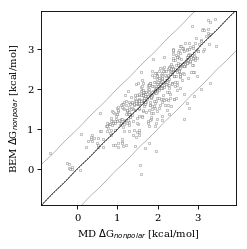

In [214]:
font={'family':'serif','size':9}
pyplot.rc('font',**font)
fig,ax = pyplot.subplots(figsize=(3,3), dpi=80)

ax.scatter(mobley[index_clean], bem[index_clean], s=5, c='w', edgecolors='k', lw=0.2)

lims = [ 
    numpy.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    numpy.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(numpy.array([lims[0],lims[1]]), numpy.array([lims[0],lims[1]]), c='k', ls='--', lw=0.5)
ax.plot(numpy.array([lims[0]+[0,1],lims[1]+[0,1]]), numpy.array([lims[0],lims[1]]), c='k', ls=':', lw=0.5)
ax.plot(numpy.array([lims[0]-[0,1],lims[1]-[0,1]]), numpy.array([lims[0],lims[1]]), c='k', ls=':', lw=0.5)


ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('MD $\Delta$G$_{nonpolar}$ [kcal/mol]')
ax.set_ylabel('BEM $\Delta$G$_{nonpolar}$ [kcal/mol]')
pyplot.subplots_adjust(left=0.15,bottom=0.11,right=0.96,top=0.99)
fig.savefig('mobley.pdf')
fig.show()

Correlation coeff bem_es vs area: 
[[ 1.          0.99892872]
 [ 0.99892872  1.        ]]


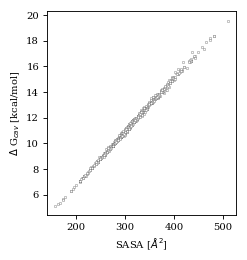

In [226]:
fig.clf()
fig,ax = pyplot.subplots(figsize=(3,3), dpi=80)

ax.scatter(areas_s[index_clean], bem_es[index_clean], s=5, c='w', edgecolors='k', lw=0.2)

lims = [ 
    numpy.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    numpy.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

#ax.plot(numpy.array([lims[0],lims[1]]), numpy.array([lims[0],lims[1]]), c='k', ls='--', lw=0.5)


#ax.set_aspect('equal')
#ax.set_xlim(lims)
#ax.set_ylim(lims)
ax.set_xlabel('SASA [$\AA^2$]')
ax.set_ylabel('$\Delta$ G$_{cav}$ [kcal/mol]')
pyplot.subplots_adjust(left=0.17,bottom=0.14,right=0.96,top=0.99)
fig.savefig('dG_cav_area.pdf')
fig.show()

#Cross correlation
correl = numpy.corrcoef(bem_es[index_clean], areas_s[index_clean])
print 'Correlation coeff bem_es vs area: '
print correl

Correlation coeff bem_ls vs area: 
[[ 1.         -0.94840775]
 [-0.94840775  1.        ]]


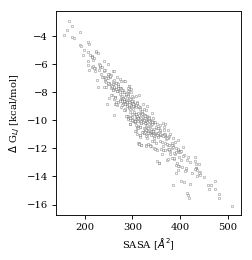

In [233]:
fig.clf()
fig,ax = pyplot.subplots(figsize=(3,3), dpi=80)

ax.scatter(areas_s[index_clean], bem_lj[index_clean], s=5, c='w', edgecolors='k', lw=0.2)

lims = [ 
    numpy.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    numpy.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

#ax.plot(numpy.array([lims[0],lims[1]]), numpy.array([lims[0],lims[1]]), c='k', ls='--', lw=0.5)


#ax.set_aspect('equal')
#ax.set_xlim(lims)
#ax.set_ylim(lims)
ax.set_xlabel('SASA [$\AA^2$]')
ax.set_ylabel('$\Delta$ G$_{LJ}$ [kcal/mol]')
pyplot.subplots_adjust(left=0.19,bottom=0.14,right=0.96,top=0.99)
fig.savefig('dG_lj_area.pdf')
fig.show()

#Cross correlation
correl = numpy.corrcoef(bem_lj[index_clean], areas_s[index_clean])
print 'Correlation coeff bem_ls vs area: '
print correl

Correlation coeff bem_es vs volume: 
[[ 1.          0.99771958]
 [ 0.99771958  1.        ]]


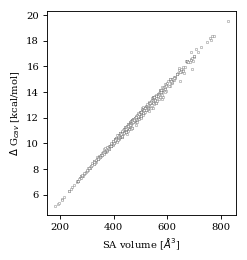

In [228]:
fig.clf()
fig,ax = pyplot.subplots(figsize=(3,3), dpi=80)

ax.scatter(volumes_s[index_clean], bem_es[index_clean], s=5, c='w', edgecolors='k', lw=0.2)

lims = [ 
    numpy.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    numpy.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

#ax.plot(numpy.array([lims[0],lims[1]]), numpy.array([lims[0],lims[1]]), c='k', ls='--', lw=0.5)


#ax.set_aspect('equal')
#ax.set_xlim(lims)
#ax.set_ylim(lims)
ax.set_xlabel('SA volume [$\AA^3$]')
ax.set_ylabel('$\Delta$ G$_{cav}$ [kcal/mol]')
pyplot.subplots_adjust(left=0.17,bottom=0.14,right=0.96,top=0.99)
fig.savefig('dG_cav_volume.pdf')
fig.show()

#Cross correlation
correl = numpy.corrcoef(bem_es[index_clean], volumes_s[index_clean])
print 'Correlation coeff bem_es vs volume: '
print correl

Correlation coeff bem_ls vs volume: 
[[ 1.         -0.95008414]
 [-0.95008414  1.        ]]


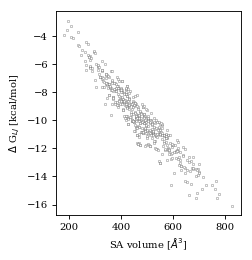

In [232]:
fig.clf()
fig,ax = pyplot.subplots(figsize=(3,3), dpi=80)

ax.scatter(volumes_s[index_clean], bem_lj[index_clean], s=5, c='w', edgecolors='k', lw=0.2)

lims = [ 
    numpy.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    numpy.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

#ax.plot(numpy.array([lims[0],lims[1]]), numpy.array([lims[0],lims[1]]), c='k', ls='--', lw=0.5)


#ax.set_aspect('equal')
#ax.set_xlim(lims)
#ax.set_ylim(lims)
ax.set_xlabel('SA volume [$\AA^3$]')
ax.set_ylabel('$\Delta$ G$_{LJ}$ [kcal/mol]')
pyplot.subplots_adjust(left=0.19,bottom=0.14,right=0.96,top=0.99)
fig.savefig('dG_lj_volume.pdf')
fig.show()

#Cross correlation
correl = numpy.corrcoef(bem_lj[index_clean], volumes_s[index_clean])
print 'Correlation coeff bem_ls vs volume: '
print correl

Correlation coeff bem vs area: 
[[ 1.          0.39867636]
 [ 0.39867636  1.        ]]


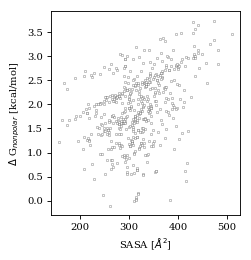

In [230]:
fig.clf()
fig,ax = pyplot.subplots(figsize=(3,3), dpi=80)

ax.scatter(areas_s[index_clean], bem[index_clean], s=5, c='w', edgecolors='k', lw=0.2)

lims = [ 
    numpy.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    numpy.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

#ax.plot(numpy.array([lims[0],lims[1]]), numpy.array([lims[0],lims[1]]), c='k', ls='--', lw=0.5)


#ax.set_aspect('equal')
#ax.set_xlim(lims)
#ax.set_ylim(lims)
ax.set_xlabel('SASA [$\AA^2$]')
ax.set_ylabel('$\Delta$ G$_{nonpolar}$ [kcal/mol]')
pyplot.subplots_adjust(left=0.17,bottom=0.14,right=0.96,top=0.99)
fig.savefig('dG_area.pdf')
fig.show()

#Cross correlation
correl = numpy.corrcoef(bem[index_clean], areas_s[index_clean])
print 'Correlation coeff bem vs area: '
print correl

Correlation coeff bem vs volume: 
[[ 1.          0.38917137]
 [ 0.38917137  1.        ]]


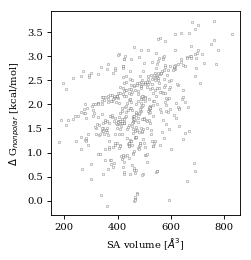

In [231]:
fig.clf()
fig,ax = pyplot.subplots(figsize=(3,3), dpi=80)

ax.scatter(volumes_s[index_clean], bem[index_clean], s=5, c='w', edgecolors='k', lw=0.2)

lims = [ 
    numpy.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    numpy.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

#ax.plot(numpy.array([lims[0],lims[1]]), numpy.array([lims[0],lims[1]]), c='k', ls='--', lw=0.5)


#ax.set_aspect('equal')
#ax.set_xlim(lims)
#ax.set_ylim(lims)
ax.set_xlabel('SA volume [$\AA^3$]')
ax.set_ylabel('$\Delta$ G$_{nonpolar}$ [kcal/mol]')
pyplot.subplots_adjust(left=0.17,bottom=0.14,right=0.96,top=0.99)
fig.savefig('dG_volume.pdf')
fig.show()

#Cross correlation
correl = numpy.corrcoef(bem[index_clean], volumes_s[index_clean])
print 'Correlation coeff bem vs volume: '
print correl